# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,7)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

$$ w_{new} = (1 - \frac{2\alpha}{C})w_{old} + \frac{2\alpha}{N}\sum_{i=1}^N\left[(y_{i} - \left\langle {X_{i},w_{old}} \right\rangle) *X_{i}\right]$$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

$$ w_{new} = (1 - \frac{2\alpha}{C})w_{old} + \frac{2\alpha}{N}\sum_{i=1}^N(y_{i} - \left\langle {X_{i},w_{old}} \right\rangle) X_{i}$$

$$ w_{new} = (1 - \frac{2\alpha}{C})w_{old} - \frac{\alpha}{N}\sum_{i=1}^N(y_{i} - \sigma\langle X_{i}, w_{old}\rangle)X_{i}$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

**Гассиан всегда положителен:(X имеет полный ранг)**
$$ Gassian = det(2X^TX) > 0 $$ (еще в этом можно убедиться, если разложить отдельно матрицы в сингулярное разложение и увидеть, что у полученной сингулярной матрицы на диагонале буду лежать квадраты собственных значений исходной матрицы, что оправдывает неотрицательность)

**Точное решение с L2 регуляризацией:** $$\omega=(X^TX + \lambda I)^{-1}X^TY$$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$$\frac{\delta}{\delta a(x_{i})}E(L|x_{i}) = - \frac{p(y_{i}=1|x_{i})}{a(x_{i})} + \frac{1-p(y_{i}=1|x_{i})}{1-a(x_{i})} = \frac{a(x_{i})-p(y_{i}=1|x_{i})}{a(x_{i})(1-a(x_{i})}=0$$

$$a(x_{i})=p(i_{i}=1|x_{i})$$
Легко видеть, что и Гессиан положительный, следовательно это точка минимума.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

Мы используем регуляризацию, чтобы штрафовать за большую норму весов векторов, а это в свою очередь является признаком переобучения). Если мы будем штрафовать за большую норму вектора $w_0$, то это значит, что мы предполагаем близость целевой переменной к 0, что в общем случае неверно. Поэтому ответ: НЕТ.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [491]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

In [544]:
a = np.array([[1,2,-3,4], [51,2,3,40], [9,20,0,-44]])
np.dot(a.T,a), np.linalg.det((np.dot(a.T,a)))

(array([[2683,  284,  150, 1648],
        [ 284,  408,    0, -792],
        [ 150,    0,   18,  108],
        [1648, -792,  108, 3552]]), 1.4679983303675893e-06)

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [492]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [493]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [494]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [545]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    X = np.asarray(X)
    X = np.hstack((np.ones((X.shape[0],1)), X))
    y = np.asarray(y)
    indexs = np.arange(y.shape[0])
    if batch_size == -1:
        batch_size = y.shape[0]-1
    if shuffle:
        np.random.shuffle(indexs)
    for i in range(0, y.shape[0] - batch_size, batch_size):
        X_batch = np.asarray(X)[indexs[i:i+batch_size]]
        y_batch = np.asarray(y)[indexs[i:i+batch_size]]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1)

In [686]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1 / (1 + np.exp(-x) + 1e-5)
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, 
                 batch_generator=batch_generator, 
                 C=-1, 
                 alpha=0.001, 
                 max_epoch=15, 
                 model_type='lin_reg', 
                 batch_size=1, 
                 threshold=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type   
        self.batch_size = batch_size
        self.threshold = threshold
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудьте тип модели (линейная или логистическая регрессия)!
        """
        X_batch = np.asarray(X_batch)
        if X_batch.shape[1] != self.weights.shape[0]:
            X_batch = np.hstack((np.ones((X_batch.shape[0],1)), X_batch)) 
        
        row_predict = np.dot(X_batch, self.weights)
        
        if self.model_type == 'lin_reg':
            loss = np.mean( (row_predict - y_batch)**2 )
        elif self.model_type == 'log_reg':
            y_pred = sigmoid(row_predict)
            loss = -np.mean( y_batch * np.log(y_pred + 1e-5) + (1 - y_batch) * np.log(1 - y_pred + 1e-5) )
            
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        N = y_batch.shape[0]
        row_predict = np.dot(X_batch, self.weights)
            
        if self.model_type == 'lin_reg':
            tmp = row_predict - y_batch # X*w - y 
            loss_grad = (2/N)*np.dot(X_batch.T, tmp) # 1/N * 2X.T * (X*w - y) - градиент (без регуляризации)
            
        elif self.model_type == 'log_reg':
            row_predict = sigmoid(row_predict)
            tmp = row_predict - y_batch # sigmoid(X*w-y) - y
            loss_grad = np.dot(tmp, X_batch) / N # 1/N * (sigmoid - y) * X - градиент (без регуляризации)
            
        if self.C != -1:
            C_weight = (2 / max(self.alpha*2.1, self.C)) * self.weights # Иначе будет w_new = -koef*w_old - ...
            C_weight[0] = 0
            loss_grad += C_weight
            
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
        
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        self.weights = np.random.rand(X.shape[1]+1)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        X = np.asarray(X)
        if X.shape[1] != self.weights.shape[0]:
            X = np.hstack((np.ones((X.shape[0],1)), X))        
            
        y_hat = np.dot(X, self.weights)
        if self.model_type == 'log_reg':
            y_hat = sigmoid(y_hat)
            
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return (y_hat > self.threshold)*1
    
def score(self, X_test, y_test): # Accuracy
    
    y_pred = predict(X_test)                    
    return np.sum(y_test == y_pred) / y_test.shape[0]

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [636]:
def plot_decision_boundary(clf):
    
    x = range(0, 8)
    print("weights:", *clf.weights)
    
    if clf.model_type == 'lin_reg':
        plt.title("lin_reg")
        print("MSE loss: %.3f" % clf.calc_loss(X, y))    
        
    elif clf.model_type == 'log_reg':
        plt.title("log_reg")
        print("BCE loss: %.3f" % clf.calc_loss(X, y))    
        
    plt.plot(x, (0.5 - clf.weights[0] - clf.weights[1]*x) / clf.weights[2]) # w0 + w1*x1 + w2*x2 = 0.5

weights: -3.958517088475597 0.9201741136160116 -0.8984746594689865
BCE loss: 0.309


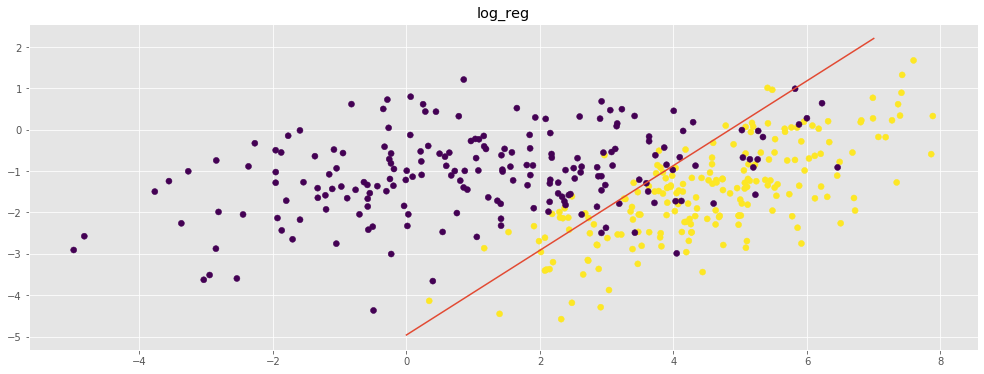

In [733]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

model = MySGDClassifier(batch_generator,
                        C = 100,
                        batch_size = -1,
                        alpha=0.01,
                        max_epoch=10000,
                        model_type="log_reg")
model.fit(X, y)
plot_decision_boundary(model)

plt.scatter(X[:,0], X[:,1], c=y);

In [550]:
model.weights

array([nan, nan, nan])

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [487]:
from sklearn.datasets import make_classification

In [488]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

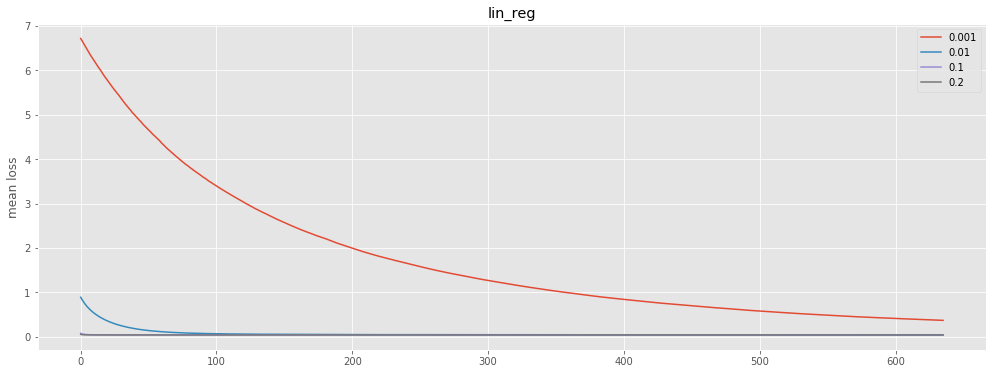

In [489]:
for alpha in [0.001, 0.01, 0.1, 0.2]:
    clf = MySGDClassifier(batch_generator,
                          C=100,
                          alpha=alpha,
                          max_epoch=15,
                          model_type='lin_reg',
                          batch_size=2000)
    clf.fit(X, y)
    N = 100
    loss = np.convolve(np.asarray(clf.errors_log["loss"]), np.ones(N)/N, 'valid')
    plt.plot(loss, label=alpha)

plt.title(str(clf.model_type))
plt.ylabel("mean loss")
plt.legend()
plt.show()

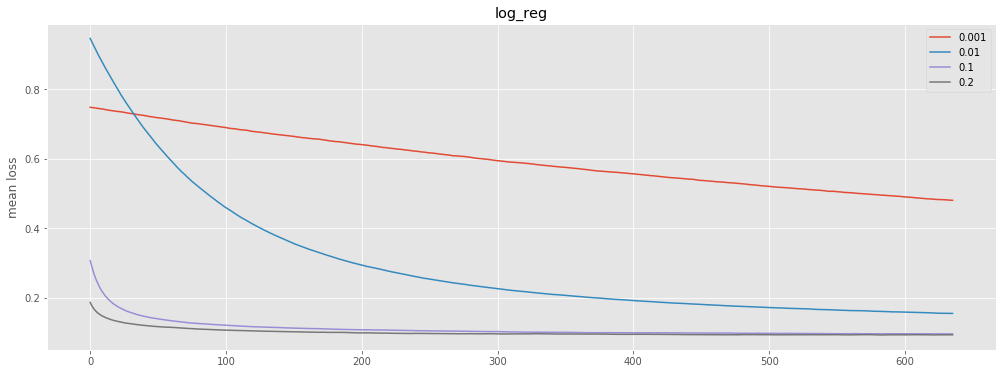

In [490]:
for alpha in [0.001, 0.01, 0.1, 0.2]:
    clf = MySGDClassifier(batch_generator,
                          C=100,
                          alpha=alpha,
                          max_epoch=15,
                          model_type='log_reg',
                          batch_size=2000)
    clf.fit(X, y)
    N = 100
    loss = np.convolve(np.asarray(clf.errors_log["loss"]), np.ones(N)/N, 'valid')
    plt.plot(loss, label=alpha)

plt.title(str(clf.model_type))
plt.ylabel("mean loss")
plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

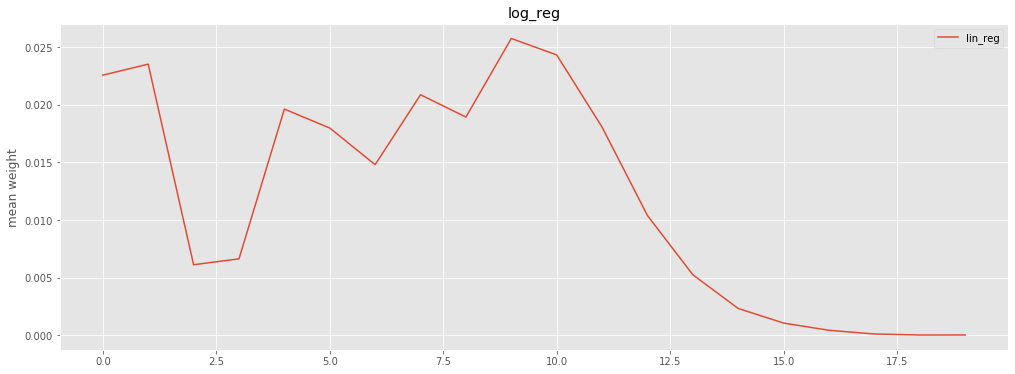

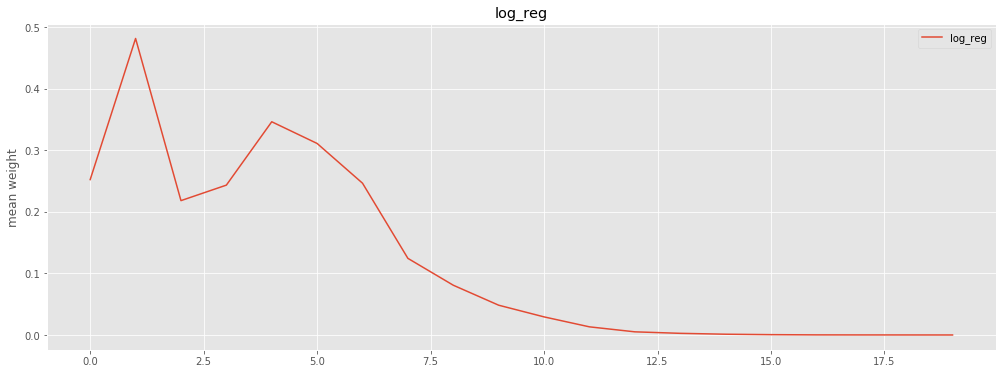

In [734]:
for model_type in ['lin_reg', 'log_reg']:
    history = {'C':[], 'mean':[]}
    for c_ in np.logspace(3, -4, 20):
        clf = MySGDClassifier(batch_generator,
                              C=c_,
                              batch_size=5,
                              alpha=0.00005, # Должен быть сильно меньше C, следует из формулы.
                              max_epoch=700,
                              model_type=model_type)
        clf.fit(X, y)
        mean_ = np.mean(clf.weights[1:])
        history['C'].append(c_)
        history['mean'].append(mean_)

    plt.plot(history['mean'], label=model_type)

    plt.title(str(model.model_type))
    plt.ylabel("mean weight")
    plt.legend()
    plt.show()

In [735]:
# Довольны ли Вы, насколько сильно уменьшились Ваши веса? 
# А должен?... Скажу лишь, что из-за того, что у меня проверяются C=~0.001, я должен сделать
#  alpha < 0.0001, но для сходимости следуетпотребуется max_epochs > 100'000, особенно для log_reg
#  , а посчитать это по очевидным причинам не получится, банально в дедлайн не уложусь, чтобы идельные
#  графики получить. Поэтому решил показать их убывание способом выше.

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [786]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [787]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [788]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [789]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [790]:
model = MySGDClassifier(batch_generator,
                        C=1000,
                        alpha=0.0005,
                        max_epoch=70,
                        model_type='lin_reg',
                        batch_size=1000)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [791]:
X = X_train.copy()
y = y_train.copy()

In [792]:
def K_fold(data, target, K_fold = 3, seed=2357):
    # Получаем tuple(пару), в каждом из которых K_fold np.array'ев - объекты и соотв-ие им метки.
    np.random.seed(seed)
    data_size = data.shape[0] // K_fold
    rows = np.random.permutation(np.arange(data_size * K_fold))
    indexes = [rows[fold*data_size:(fold+1)*data_size].tolist() for fold in range(K_fold)]
    return np.array([data[indx] for indx in indexes]), np.array([np.asarray(target)[indx] for indx in indexes])

In [793]:
def cross_val_score(objects, targets, model, metric=None, num_fold=3, scaler=None, seed=2357):
    X, y = K_fold(objects, targets, K_fold=num_fold, seed=seed)
    score_history = []

    for i in range(num_fold):
        train_index = [indx for indx in range(0,i)] + [indx for indx in range(i+1,num_fold)]

        X_train = X[train_index[0]]
        y_train = y[train_index[0]]
      
        for index in train_index[1:]:
            X_train = np.vstack((X_train,X[index]))
            y_train = np.hstack((y_train,y[index]))
            
        X_train = X_train.copy()

        X_val, y_val = X[i].copy(), y[i].copy()
        
        if scaler != None:
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            
        model.fit(X_train, y_train)
        if metric == None:
            score = model.score(X_val, y_val)
        else:
            score = metric(model.predict(X_val), y_val)
        score_history.append(score)
    return score_history

In [794]:
from sklearn.metrics import f1_score as F1
from sklearn.metrics import accuracy_score as ACU
from sklearn.metrics import roc_auc_score as ROC

In [803]:
# parametrs = {'C': [0.05, 0.1, 0.5, 1, 10, 15, 30, 50, 100, 300, -1],
#              'batch_size': [1, 10, 100, 1000, 10000],
#              'model_type': ['lin_reg', 'log_reg'],
#              'alpha': [0.0001, 0.001, 0.01],
#              'max_epoch': [20, 200, 2000]}

# score = {ACU: [], ROC: [], F1: []}

In [801]:
# all_history = pd.DataFrame({'C':              [],
#                             'batch_size':     [],
#                             'model_type':     [],
#                             'alpha':          [],
#                             'max_epoch':      [],
#                             'accuracy_score': [],
#                             'ROC_AUC_score':  [],
#                             'f1_score':       []})
# all_history

,C,batch_size,model_type,alpha,max_epoch,accuracy_score,ROC_AUC_score,f1_score


In [819]:
# %timeit one_iteration_below()
# Попросту не успевал, все это перебрать, прошу прощения, но код красивый) Поэтому оставлю его все равно тут:))

1min 49s ± 3.13 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [818]:
#     for C in parametrs['C']:
#         for batch_size in parametrs['batch_size']:
#             for model_type in parametrs['model_type']:
#                 for alpha in parametrs['alpha']:
#                     for max_epoch in parametrs['max_epoch']:
#                         model = MySGDClassifier(C=C,
#                                                 batch_size=batch_size,
#                                                 model_type=model_type,
#                                                 alpha=alpha,
#                                                 max_epoch=max_epoch)
#                         for metric in [ACU, ROC, F1]:
#                             scores = cross_val_score(X, y,
#                                                      model,
#                                                      metric=metric,
#                                                      num_fold=3,
#                                                      scaler=StandardScaler())
#                             score[metric] = np.mean(scores)

#                         new_line = pd.DataFrame({'C':              [C],
#                                                  'batch_size':     [batch_size],
#                                                  'model_type':     [model_type],
#                                                  'alpha':          [alpha],
#                                                  'max_epoch':      [max_epoch],
#                                                  'accuracy_score': [score[ACU]],
#                                                  'ROC_AUC_score':  [score[ROC]],
#                                                  'f1_score':       [score[F1]]})

#                         all_history = all_history.append(new_line) 

In [ ]:
for scale_flag in [False, True]:
    
    if scale_flag:
        scaler = StandardScaler()
    else:
        scaler = None

    for model_type in ['lin_reg', 'log_reg']:
        # print("model: ", model_type, ",  scale: ", scale_flag)
    
        score_history = {'batch_size': [], 'loss': []}
        for batch_size in [1, 10, 100, 500, 750, 2000, 5000, 10000, 20000, 30000]:
            model = MySGDClassifier(batch_size=batch_size,
                                    alpha=0.001,
                                    model_type=model_type)

            scores = cross_val_score(X, y, 
                                     model, 
                                     metric=f1_score, 
                                     num_fold=2, 
                                     scaler=scaler)
            score = np.mean(scores)
            # print("batch_size: %.0f," % batch_size, " score: %.4f" % score)
            score_history['loss'].append(score)
            score_history['batch_size'].append(model.batch_size)    

        plt.plot(score_history['batch_size'], score_history['loss'], label=[model_type, scale_flag])
        # print()

plt.rcParams['figure.figsize'] = (17,6)
plt.title("f1_score")
plt.legend()
plt.ylabel("val_score")
plt.xlabel("batch_size")
plt.show()

model:  lin_reg ,  scale:  False


/home/david/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


model:  log_reg ,  scale:  False
model:  lin_reg ,  scale:  True
model:  log_reg ,  scale:  True


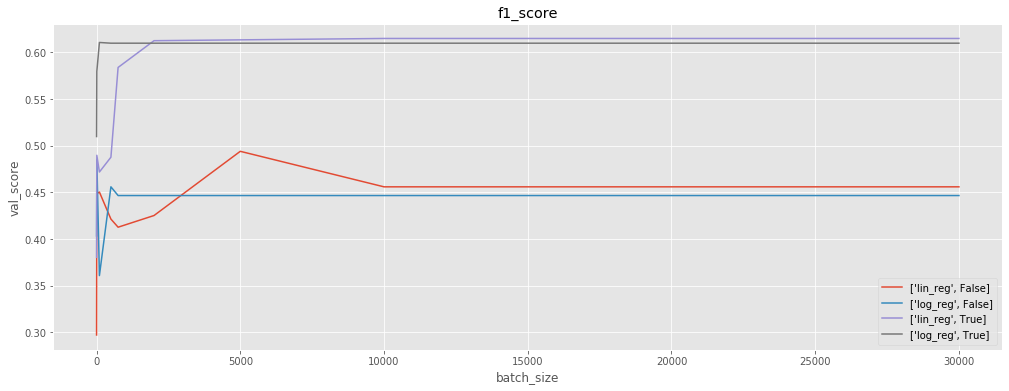

In [448]:
for scale_flag in [False, True]:
    
    if scale_flag:
        scaler = StandardScaler()
    else:
        scaler = None

    for model_type in ['lin_reg', 'log_reg']:
        # print("model: ", model_type, ",  scale: ", scale_flag)
    
        score_history = {'batch_size': [], 'loss': []}
        for batch_size in [1, 10, 100, 500, 750, 2000, 5000, 10000, 20000, 30000]:
            model = MySGDClassifier(batch_size=batch_size,
                                    alpha=0.001,
                                    model_type=model_type)

            scores = cross_val_score(X, y, 
                                     model, 
                                     metric=f1_score, 
                                     num_fold=2, 
                                     scaler=scaler)
            score = np.mean(scores)
            # print("batch_size: %.0f," % batch_size, " score: %.4f" % score)
            score_history['loss'].append(score)
            score_history['batch_size'].append(model.batch_size)    

        plt.plot(score_history['batch_size'], score_history['loss'], label=[model_type, scale_flag])
        # print()

plt.rcParams['figure.figsize'] = (17,6)
plt.title("f1_score")
plt.legend()
plt.ylabel("val_score")
plt.xlabel("batch_size")
plt.show()

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

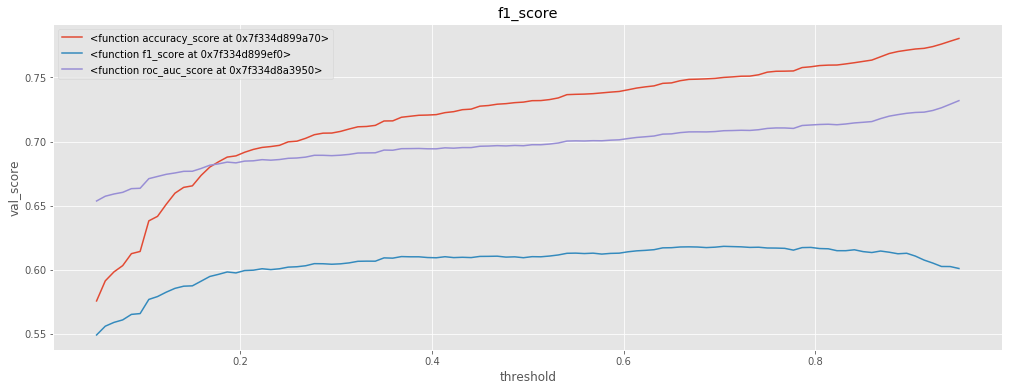

In [447]:
scaler = StandardScaler()

for metric in [ACU, F1, ROC]:
    score_history = {'threshold': [], 'loss': []}
    for threshold in np.linspace(0.05, 0.95, 100):
        model = MySGDClassifier(batch_size=10000,
                                threshold=threshold,
                                C=0.001,
                                alpha=0.001,
                                model_type='log_reg')       
        
        scores = cross_val_score(X, y, 
                                 model, 
                                 metric=metric, 
                                 num_fold=3, 
                                 scaler=scaler)
        score = np.mean(scores)
        #print("threshold: %.2f," % threshold, " score: %.4f" % score)
        score_history['loss'].append(score)
        score_history['threshold'].append(threshold)    

    plt.plot(score_history['threshold'], score_history['loss'], label=metric)

plt.rcParams['figure.figsize'] = (17,6)
plt.title("f1_score")
plt.legend()
plt.ylabel("val_score")
plt.xlabel("threshold")
plt.show()

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [453]:
import pandas as pd
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
X_test = np.array(X_test)
groups_test = np.array(groups_test)

In [472]:
model = MySGDClassifier(batch_size=10000,
                        threshold=0.7,
                        alpha=0.001,
                        model_type='log_reg') 
scaler.fit(X_train)
model.fit(scaler.transform(X_train), y_train)
y_pred = model.predict(scaler.transform(X_test))

In [473]:
data = test_data
data['target'] = y_pred
data = data.drop(['group_id', 'doc_id'], axis=1)
data

,pair_id,target
0,11691,1
1,11692,1
2,11693,1
3,11694,1
4,11695,1
...,...,...
16622,28313,0
16623,28314,1
16624,28315,1
16625,28316,1


In [474]:
data.to_csv("submission.csv", index=False)
#data.head()

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Всё очень хорошо, но вот квизы считаю иногда некорректно формулируются) 

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

Мне очень импонирует работа преподователей Техносферы, такое редко бывает, но мои ожидания были ниже того, что по итогу я вижу, очень круто мне всё безумно нравится. Но конечно же совершенства не существует, поэтому считаю нужным сказать легкий недочет, который по сути высос из пальца) Мне очень нравится политика преподавателей Техносферы о том, чтобы не снижать оценки за неправильные ответы\решения т.е. что есть возмонжость за несколько попыток все-таки получить фул балл, вроде вот думаю, наконец-то в России отошли от старых стандартов школ и принципов СССР, я считаю эту систему наилучшей из возмножных, поэтому любое отклонение от нее считаю нежелательным, поэтому тоже считаю, что снимать баллы за квизы отправиленные чуть-чуть позже из-за медленного вайфая, снимать за неоформленную фамилию в названии работы, код стайл и другие вещи без которых преподователю будет не удобно неправильными, конечно это наша вина, преподователю не хочется искать среди неподписанных работ их владельцев или разбираться в очень "непонятно" написанном коде, но все-таки не считаю корректным это штрафовать баллами, все-таки это не говорит о незнании или плохом знании материала студентами, можно отчислять допустим, за какое-то кол-во таких нарушений))) Но баллы снимать не надо